# Plot TM Data Fits
This notebook demonstrates how models can be loaded from our pre-saved weights and used to predict the complex TM.
The accuracy of predications is visualized by plotting them against data recorded in this paper: [https://doi.org/10.1103/PhysRevX.11.021060]

All models are saved as full pytorch so they can be loaded from files without importing any custom classes using:
```python
torch.load(<path-to-model>, weights_only=False)
```

In [1]:
# General imports
import torch, os
import numpy as np
from matplotlib import pyplot as plt

from torch.utils.data import Subset

from oil.complex import ComplexConverter # Used to convert split-value complex representations (used for ml) into true torch.complex values.
from oil.datasets import HDF5Dataset # Used to load compressed training data.

## Load the models
Model class definitions will automatically be loaded as well.

In [2]:
# Load the model weights 
model_names = ['small-mlp', 'siren', 'f-net', 'small-mlp-mse', 'siren-mse', 'f-net-mse'] # List of models to be loaded 
models = {}
for _name in model_names:
    models[_name] = torch.load(os.path.join("Data","Weights","plotWeights_tm",_name), weights_only=False)

In [3]:
# Display f-net details 
models['f-net']

FourierFeatureMLP(
  (features): FourierFeatures(in_features=1, out_features=11, frequencies=5)
  (mlp): MLP(
    (0): Linear(in_features=11, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=800, bias=True)
  )
)

## Load the Dataset
Note the the data loaded here was recorded by Matthès, Bromberg, de Rosny, and Popoff for this paper: [https://doi.org/10.1103/PhysRevX.11.021060]

In [4]:
tm_dataset = HDF5Dataset.load(os.path.join('Data','Data','Compression_20-mode','TM_dataset.h5'))

# Get data information 
STEPS = len(tm_dataset)
MODES = len(tm_dataset[0][-1])

idxs = list(range(0, STEPS, 2))
even_data = Subset(tm_dataset, idxs)
idxs = list(range(1, STEPS, 2))
odd_data = Subset(tm_dataset, idxs)

# Data is stored as a tuple: (input deformation, output flattened tm)
tm_dataset[0]

(tensor(0., dtype=torch.float64),
 tensor([[-9.2991e-01-2.4430e-01j,  1.8551e-01+6.8496e-02j,
          -2.2407e-02-7.8154e-02j,  2.4020e-02+3.4272e-02j,
           8.9064e-03-5.0639e-03j, -2.2272e-02+1.0891e-02j,
          -8.7189e-03+7.7251e-04j,  1.1107e-02-4.7184e-04j,
          -2.2509e-02-2.6927e-02j, -3.0797e-02+3.4339e-02j,
          -1.4116e-01-4.7107e-02j, -2.4309e-03+1.3363e-02j,
          -9.4476e-03-2.2293e-02j,  4.8435e-03+2.3457e-02j,
           1.9919e-04+4.3594e-05j, -8.0491e-03+1.6378e-04j,
           9.9409e-05-3.9460e-04j,  3.3020e-03-3.4958e-03j,
          -1.3690e-02-3.6432e-03j, -4.1928e-03+6.1012e-03j],
         [-4.9995e-02-1.8904e-01j, -9.5295e-02-9.2041e-01j,
           6.1970e-02+1.1469e-01j,  1.7908e-02+6.2126e-02j,
           2.8083e-02+1.1692e-02j,  5.9922e-02+2.1985e-01j,
           7.3567e-03+1.2788e-02j, -2.7528e-02-3.6407e-02j,
           2.6052e-02+4.8867e-02j, -2.0061e-02+4.5772e-03j,
           2.4333e-02-1.9214e-02j,  9.9510e-02-1.0514e-01j,
     

# Plot Data

In [5]:
MODE_IN = 4 # Input mode (TM column)
MODE_OUT = 7 # Output mode (TM row)

Generate the reference data

In [6]:
targs_fnet = np.zeros((STEPS, 1), dtype=complex)
targs_even = np.zeros((STEPS//2, 1), dtype=complex)
targs_odd = np.zeros((STEPS//2, 1), dtype=complex)
preds_test = np.zeros((STEPS, 1), dtype=complex)

for _i in range(STEPS):
    x, tm_flat = tm_dataset[_i]
    targ_tm = tm_flat.detach().numpy().reshape((MODES, MODES))
    targs_fnet[_i] = targ_tm[MODE_OUT,MODE_IN]
    if _i%2 == 0:
        targs_even[_i//2]=targ_tm[MODE_OUT,MODE_IN]
    else:
        targs_odd[(_i-1)//2]=targ_tm[MODE_OUT,MODE_IN]

KeyError: 'srien'

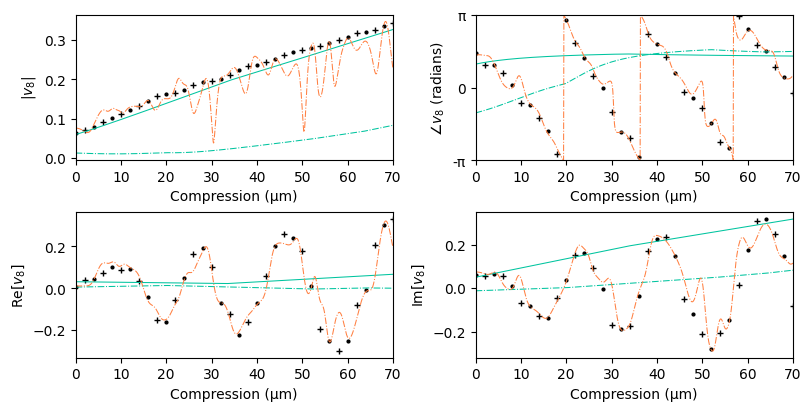

In [ ]:
LINE_WIDTH = 0.75
DATA_COLOR = "#000000"
MARKER_SIZE = 4
TEST_MARKER = "+"
TRAIN_MARKER = "."

plot_info = {
    'small-mlp-mse': ["#00C49F", "-.", "*", "MLP (MSE)", LINE_WIDTH],
    'small-mlp': ["#00C49F", "-", "*", "MLP (Curriculum)", LINE_WIDTH],
    'siren-mse': ["#FF8042", "-.", "", "SIREN (MSE)", LINE_WIDTH],
    'siren': ["#FFBB28", "-", "", "SIREN (Curriculum)", LINE_WIDTH],
    'f-net-mse': ["#8884D8", "-.", "", "FNET (MSE)", 1],
    'f-net':["#0088FE", "-", "", "FNET (Curriculum)", 1]
}

re_im_cc = ComplexConverter(expand_method='concat',representation='real-imag') # Formats network outputs

fig, axs = plt.subplots(2,2,layout='constrained', figsize=(8,4))

# Assign axes
abs_ax = axs[0,0]
phase_ax = axs[0,1]
re_ax = axs[1,0]
im_ax = axs[1,1]

# Label axes
for _ax in axs.flat:
    _ax.set_xlabel("Compression (μm)")
    _ax.set_xlim([0,70])

    
abs_ax.set_ylabel(fr"$|v_{{{MODE_OUT+1}}}|$")
phase_ax.set_ylabel(fr"$\angle v_{{{MODE_OUT+1}}}$ (radians)")
re_ax.set_ylabel(fr"$\text{{Re}}[v_{{{MODE_OUT+1}}}]$")
im_ax.set_ylabel(fr"$\text{{Im}}[v_{{{MODE_OUT+1}}}]$")


# Plot data
# Mag
abs_ax.plot(2*np.linspace(0,34,18),np.abs(targs_even), linestyle="", marker=TRAIN_MARKER, color=DATA_COLOR, label="Train Data", markersize=MARKER_SIZE)
abs_ax.plot(2*np.linspace(1,35,18),np.abs(targs_odd), linestyle="", marker=TEST_MARKER, color=DATA_COLOR, label="Test Data", markersize=MARKER_SIZE)
# Phase
phase_ax.plot(2*np.linspace(0,34,18),np.angle(targs_even), linestyle="", marker=TRAIN_MARKER, color=DATA_COLOR, label="Train Data", markersize=MARKER_SIZE)
phase_ax.plot(2*np.linspace(1,35,18),np.angle(targs_odd), linestyle="", marker=TEST_MARKER, color=DATA_COLOR, label="Test Data", markersize=MARKER_SIZE)
# Re
re_ax.plot(2*np.linspace(0,34,18),np.real(targs_even), linestyle="", marker=TRAIN_MARKER, color=DATA_COLOR, label="Train Data", markersize=MARKER_SIZE)
re_ax.plot(2*np.linspace(1,35,18),np.real(targs_odd), linestyle="", marker=TEST_MARKER, color=DATA_COLOR, label="Test Data", markersize=MARKER_SIZE)
# Im
im_ax.plot(2*np.linspace(0,34,18),np.imag(targs_even), linestyle="", marker=TRAIN_MARKER, color=DATA_COLOR, label="Train Data", markersize=MARKER_SIZE)
im_ax.plot(2*np.linspace(1,35,18),np.imag(targs_odd), linestyle="", marker=TEST_MARKER, color=DATA_COLOR, label="Test Data", markersize=MARKER_SIZE)


phase_ax.set_ylim([-np.pi, np.pi])

ls = [-np.pi,0,np.pi]
#plt.yticks(ls,["-180°","0","180°"])
phase_ax.set_yticks(ls,["-π","0","π"])

# Plot model
for key, info in plot_info.items():
    model = models[key]
    model.eval()

    fine_x = torch.linspace(0,1,1000).unsqueeze(1)
    fine_y = re_im_cc.to_complex(model(fine_x)).detach().numpy().reshape((1000,MODES,MODES))[:,MODE_OUT,MODE_IN]

    #abs
    abs_ax.plot(2*(STEPS-1)*fine_x.detach().numpy(), np.abs(fine_y),
             color=info[0], linestyle=info[1], label=info[3], linewidth=info[4])

    #angle
    phase_ax.plot(2*(STEPS-1)*fine_x.detach().numpy(), np.angle(fine_y),
             color=info[0], linestyle=info[1], label=info[3], linewidth=info[4])

    # re
    re_ax.plot(2*(STEPS-1)*fine_x.detach().numpy(), np.real(fine_y),
             color=info[0], linestyle=info[1], label=info[3], linewidth=info[4])

    # im
    im_ax.plot(2*(STEPS-1)*fine_x.detach().numpy(), np.imag(fine_y),
             color=info[0], linestyle=info[1], label=info[3], linewidth=info[4])



handles, labels = abs_ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='outside upper center', ncols=(len(model_names)+2)//2, fontsize=9)

plt.show()